In [2]:
# general tools
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import io
import re
import datetime as dt
import json
import requests
import scipy as sp
import numpy as np
import tempfile
import random
import time
import math
import statistics
import os
from typing import Tuple, Dict, List
import sys
import warnings
warnings.filterwarnings('ignore')

# preprocessing & utils
import nltk
from nltk import pos_tag
from nltk import word_tokenize
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# ml models
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neural_network import MLPClassifier

# others
from wordcloud import WordCloud
from matplotlib.ticker import FormatStrFormatter

<center>
    <h3>Constant</h3>
</center>

In [3]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

<center>
    <h3>Utility Function</h3>
</center>

In [4]:
# processsing
def pipe_cleaningText(text: str) -> str:
    txt = text.lower()
    return txt

def pipe_removeStopWords(text: str, tokenized: bool = False) -> str:
    if tokenized:
        return " ".join([w for w in text.split(" ") if w not in stop_words])
    return " ".join([w for w in word_tokenize(text) if w not in stop_words])

def pipe_lemmatization(text: str, tokenized: bool = False) -> str:
    txt = ""
    collections = word_tokenize(text) if not tokenized else text.split(" ")
    for w in collections:
        txt += lemmatizer.lemmatize(w) + ' '
    return txt.strip()

def pipe_addPos(text: str, tokenized: bool = False) -> str:
    txt = ""
    collections = word_tokenize(text) if not tokenized else text.split(" ")
    for w in pos_tag(collections):
        txt += '__'.join(w) + ' '
    return txt.strip()

def pipe_normalized(text: str, bin: int, tokenized: bool = False) -> str:
    txt = ""
    collections = word_tokenize(text) if not tokenized else text.split(" ")
    n = len(collections)
    for i, w in enumerate(collections):
        normVal = math.floor((i / (n - 1)) * (bin - 1)) + 1 if n != 1 else 1
        txt += w + '__' + str(normVal) + ' '
    return txt.strip()

def pipe_subjectCleaning(text: str, tokenized: bool = False) -> str:
    txt = ""
    collections = sent_tokenize(text) if not tokenized else text.split(" ")
    for s in collections:
        for w in pos_tag(word_tokenize(s)):
            if w[1] != 'NNP':
                continue
            txt += w[0] + ' '
    return txt.strip()

# feature extraction
def feature_tfidfUni(series: pd.Series, max_features=None) -> Tuple[sp.sparse.csr_matrix, TfidfVectorizer]:
    tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,1), max_features=max_features)
    tfidf_vectorizer.fit(series)
    return tfidf_vectorizer.transform(series), tfidf_vectorizer

def feature_bowUni(series: pd.Series, max_features=None) -> Tuple[sp.sparse.csr_matrix, CountVectorizer]:
    bow_vectorizer = CountVectorizer(ngram_range=(1,1), max_features=max_features)
    bow_vectorizer.fit(series)
    return bow_vectorizer.transform(series), bow_vectorizer

def feature_tfidfUniBi(series: pd.Series, max_features=None) -> Tuple[sp.sparse.csr_matrix, TfidfVectorizer]:
    tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=max_features)
    tfidf_vectorizer.fit(series)
    return tfidf_vectorizer.transform(series), tfidf_vectorizer

def feature_bowUniBi(series: pd.Series, max_features=None) -> Tuple[sp.sparse.csr_matrix, CountVectorizer]:
    bow_vectorizer = CountVectorizer(ngram_range=(1,2), max_features=max_features)
    bow_vectorizer.fit(series)
    return bow_vectorizer.transform(series), bow_vectorizer

# sampling
def balancing_upsampling(data: pd.DataFrame, target: int=None) -> pd.DataFrame:
    group_res = data.groupby(by=['overall'])['overall'].count()
    highest_n = max(group_res.values) if not target else target
    thedata = data[data.overall == group_res[group_res == highest_n].index[0]] if not target else data.drop(data.index)
    for i in group_res.index:
        if group_res.loc[i] == highest_n:
            continue
        tdata = data[data.overall == i]
        sample_ind = np.random.choice(tdata.index, highest_n - group_res.loc[i], replace=True)
        thedata = pd.concat([thedata, tdata, tdata.loc[sample_ind]])
    return thedata

def balancing_downsampling(data: pd.DataFrame, target: int=None) -> pd.DataFrame:
    group_res = data.groupby(by=['overall'])['overall'].count()
    lowest_n = min(group_res.values) if not target else target
    thedata = data[data.overall == group_res[group_res == lowest_n].index[0]] if not target else data.drop(data.index)
    for i in group_res.index:
        if group_res.loc[i] == lowest_n:
            continue
        tdata = data[data.overall == i]
        sample_ind = np.random.choice(tdata.index, lowest_n, replace=False)
        thedata = pd.concat([thedata, tdata.loc[sample_ind]])
    return thedata

# testing
def accuracyTrainTest(model, trainX: np.array, trainY: np.array, valX: np.array, valY: np.array, testX: np.array, testY: np.array) -> Tuple[float, float, float]:
    mod = model.fit(trainX, trainY)
    yfit = mod.predict(trainX)
    ypredVal = mod.predict(valX)
    ypredTest = mod.predict(testX)
    
    # train result, validation result, test result
    return accuracy_score(trainY, yfit), accuracy_score(valY, ypredVal), accuracy_score(testY, ypredTest)
    
def loop_testing(model, n_test: int, xArr: sp.sparse.csr_matrix, yArr: np.array, testXArr: sp.sparse.csr_matrix, testYArr: np.array) -> Dict[str, List[float]]:
    thedict = {}

    i = 0
    n = xArr.shape[0]
    n_sample = math.ceil(n / n_test)
    x_sam, y_sam = np.array([]), np.array([])
    while i < n_test:
        percent_sample = n_sample/xArr.shape[0]
        if percent_sample >= 1:
            xmain, ymain = xArr, yArr
        else:
            xmain, xArr, ymain, yArr = train_test_split(xArr, yArr, train_size=percent_sample, stratify=yArr, random_state=123)
        
        x_sam = sp.sparse.vstack((x_sam, xmain)) if x_sam.shape[0] != 0 else xmain
        y_sam = np.hstack((y_sam, ymain)) if y_sam.shape[0] != 0 else ymain
        xtrain, xtest, ytrain, ytest = train_test_split(x_sam, y_sam, train_size=0.9, stratify=y_sam, random_state=123)

        resTrain, resVal, resTest = accuracyTrainTest(model, xtrain, ytrain, xtest, ytest, testXArr, testYArr)
        thedict[x_sam.shape[0]] = [resTrain, resVal, resTest]

        i += 1
    return thedict

# visualization
def show_result(ypred: np.array, ytarget: np.array) -> None:
    label = ['Positive', 'Neutral', 'Negative']
    report = classification_report(ypred, ytarget, labels=label)
    conf_matrix = confusion_matrix(ypred, ytarget, labels=label)

    group_names = ['True Pos', 'False Neu', 'False Neg',
                   'False Pos', 'True Neu', 'False Neg',
                   'False Pos', 'False Neu', 'True Neg']
    group_percentages = ['{0:.2%}'.format(value) for value in conf_matrix.flatten() / np.sum(conf_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_percentages, conf_matrix.flatten())]
    labels = np.asarray(labels).reshape(3, 3)

    df_cm = pd.DataFrame(data=conf_matrix, index=label, columns=label)

    print(report)
    fix, axe = plt.subplots(figsize=(15, 8), nrows=1, ncols=1)
    sns.heatmap(df_cm, xticklabels=label, yticklabels=label, annot=labels, ax=axe, cmap = 'Blues', fmt = '')
    plt.show();

# visualization
def show_result2group(ypred: np.array, ytarget: np.array) -> None:
    label = ['Positive', 'Negative']
    report = classification_report(ypred, ytarget, labels=label)
    conf_matrix = confusion_matrix(ypred, ytarget, labels=label)

    group_names = ['True Pos', 'False Neg',
                   'False Pos', 'True Neg']
    group_percentages = ['{0:.2%}'.format(value) for value in conf_matrix.flatten() / np.sum(conf_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_percentages, conf_matrix.flatten())]
    labels = np.asarray(labels).reshape(2,2)

    df_cm = pd.DataFrame(data=conf_matrix, index=label, columns=label)

    print(report)
    fix, axe = plt.subplots(figsize=(15, 8), nrows=1, ncols=1)
    sns.heatmap(df_cm, xticklabels=label, yticklabels=label, annot=labels, ax=axe, cmap = 'Blues', fmt = '')
    plt.show();

def show_result5group(ypred: np.array, ytarget: np.array) -> None:
    label = [1,2,3,4,5][::-1]
    report = classification_report(ypred, ytarget, labels=label)
    conf_matrix = confusion_matrix(ypred, ytarget, labels=label)

    group_names = ['True Pos', 'False Meh-Pos', 'False Neu', 'False Meh-Neg', 'False Neg',
                   'False Pos', 'True Meh-Pos', 'False Neu', 'False Meh-Neg', 'False Neg',
                   'False Pos', 'False Meh-Pos', 'True Neu', 'False Meh-Neg', 'False Neg',
                   'False Pos', 'False Meh-Pos', 'False Neu', 'True Meh-Neg', 'False Neg',
                   'False Pos', 'False Meh-Pos', 'False Neu', 'False Meh-Neg', 'True Neg']
    group_percentages = ['{0:.2%}'.format(value) for value in conf_matrix.flatten() / np.sum(conf_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_percentages, conf_matrix.flatten())]
    labels = np.asarray(labels).reshape(5, 5)

    df_cm = pd.DataFrame(data=conf_matrix, index=label, columns=label)

    print(report)
    fix, axe = plt.subplots(figsize=(15, 8), nrows=1, ncols=1)
    sns.heatmap(df_cm, xticklabels=label, yticklabels=label, annot=labels, ax=axe, cmap = 'Blues', fmt = '')
    plt.show();

def visualized_loopTesting(result_loopTesting: Dict[str, List[float]]) -> None:
    train_res, val_res, test_res = dict(), dict(), dict()
    for res in result_loopTesting:
        train_res[res] = result[res][0]
        val_res[res] = result[res][1]
        test_res[res] = result[res][2]

    fig, axe = plt.subplots(figsize=(15, 8), nrows=1, ncols=1)
    sns.lineplot(y=train_res.values(), x=train_res.keys() , ax=axe, label='train-result')
    sns.lineplot(y=val_res.values(), x=val_res.keys(), ax=axe, label='val-result')
    sns.lineplot(y=test_res.values(), x=test_res.keys(), ax=axe, label='test-result')
    axe.set_title("Highest Score: {}".format(max(test_res.values())))
    axe.set_xlabel("Dataset Size")
    axe.set_ylabel("Accuracy")
    axe.set_ylim([0.65, 1.0])
    axe.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    plt.show();

# others
def correlation(x: list, y: list) -> float:
    x = np.array(x)
    y = np.array(y)
    bar_x = x.mean()
    bar_y = y.mean()
    sum_xixbar_yiybar = sum((x - bar_x) * (y - bar_y))
    sum_xixbar2 = sum((x - bar_x) ** 2)
    sum_yiybar2 = sum((y - bar_y) ** 2)

    numer = sum_xixbar_yiybar
    denom = (sum_xixbar2 * sum_yiybar2) ** (1 / 2)

    r = numer / denom if denom != 0 else 0

    return r

def gradient(x: list, y: list) -> float:
    p1 = [x[0], y[0]]
    p2 = [x[2], y[2]]

    numer = p1[1] - p2[1]
    denom = p1[0] - p2[0]

    return numer / denom
    

<center>
    <h3>Pre-Process</h3>
</center>

Goals
- Try more extensive features (CBOW & BERT)
    - Test builtin vs trained

In [5]:
df = pd.read_csv('../data/Amazon_Electronics.csv')

In [6]:
df.describe()

,overall,unixReviewTime
count,2.094154e+07,2.094154e+07
mean,4.073490e+00,1.425820e+09
std,1.385862e+00,7.772530e+07
min,1.000000e+00,8.811936e+08
25%,4.000000e+00,1.393891e+09
50%,5.000000e+00,1.440461e+09
75%,5.000000e+00,1.478563e+09
max,5.000000e+00,1.538698e+09


In [7]:
df.isnull().sum()

overall                  0
verified                 0
reviewTime               0
reviewerID               0
asin                     0
style             10476370
reviewerName          2668
reviewText            9670
summary               4896
unixReviewTime           0
vote              18254610
image             20594419
dtype: int64

<AxesSubplot:xlabel='overall'>

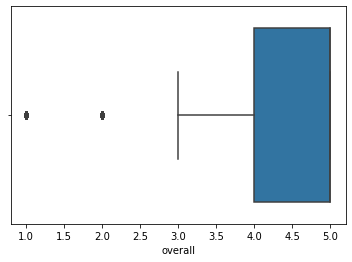

In [8]:
sns.boxplot(df['overall'])

<AxesSubplot:xlabel='overall', ylabel='Count'>

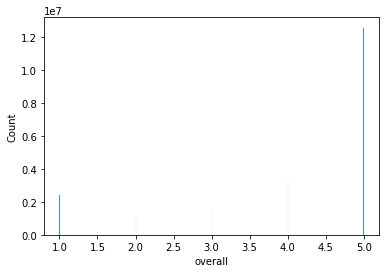

In [9]:
sns.histplot(df['overall'])

In [10]:
dfdata = df[['reviewText', 'overall']]
dfdata.head()

,reviewText,overall
0,This was the first time I read Garcia-Aguilera...,5
1,"As with all of Ms. Garcia-Aguilera's books, I ...",5
2,I've not read any of Ms Aguilera's works befor...,5
3,This romance novel is right up there with the ...,4
4,Carolina Garcia Aguilera has done it again. S...,5


In [11]:
dfdata.isnull().sum()

reviewText    9670
overall          0
dtype: int64

In [12]:
dfdata = dfdata[(~dfdata.isnull().any(axis=1)) & (dfdata.reviewText.apply(lambda x: str(x).strip() != ""))]

In [13]:
dfdata.isnull().sum()

reviewText    0
overall       0
dtype: int64

In [14]:
# filter to only get 1 & 5 output
dfdata = dfdata[dfdata['overall'].apply(lambda x: x in (1, 5))]

In [15]:
target_n = 500 * 1000
dfdataMain, _ = train_test_split(dfdata, train_size=target_n / dfdata.shape[0], stratify=dfdata['overall'], random_state=123)

In [16]:
dfdataMain.shape

(500000, 2)

In [17]:
# for training & testing
target_n = 480 * 1000
dfdataTrain, dfdataTest = train_test_split(dfdataMain, train_size=target_n / dfdataMain.shape[0], stratify=dfdataMain['overall'], random_state=123)

In [18]:
# for validation
target_n = 48 * 1000
dfdataValid, dfdataTrainSub = train_test_split(dfdataTrain, train_size=target_n / dfdataTrain.shape[0], stratify=dfdataTrain['overall'], random_state=123)

In [19]:
# for validation training & testing
target_n = 45 * 1000
dfdataValidTrain, dfdataValidTest = train_test_split(dfdataValid, train_size=target_n / dfdataValid.shape[0], stratify=dfdataValid['overall'], random_state=123)

<AxesSubplot:xlabel='overall', ylabel='Count'>

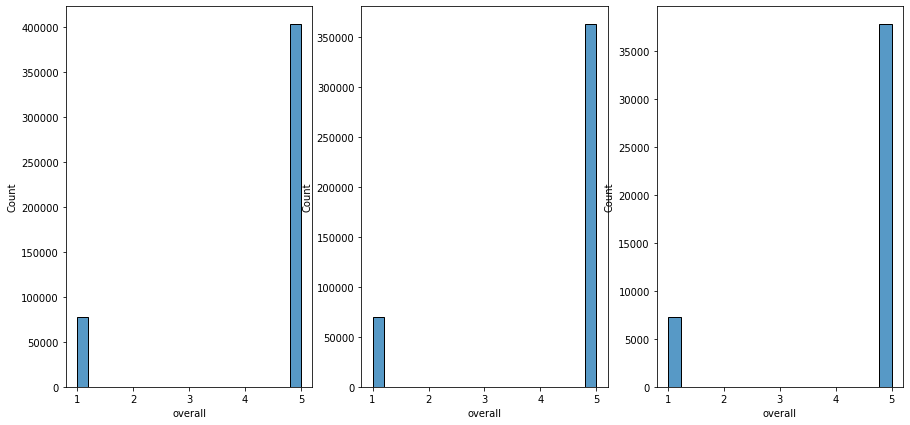

In [20]:
fig, axes = plt.subplots(figsize=(15,7), nrows=1, ncols=3)
sns.histplot(dfdataTrain['overall'], ax=axes[0])
sns.histplot(dfdataTrainSub['overall'], ax=axes[1])
sns.histplot(dfdataValidTrain['overall'], ax=axes[2])

In [21]:
statistics.variance(dfdataValidTrain.groupby(by=['overall'])['overall'].count().values)

465613128

In [22]:
# validation for processing

In [23]:
# upsampling minority group for validation training
if statistics.variance(dfdataValidTrain.groupby(by=['overall'])['overall'].count().values) >= 10 * 1000:
    dfdataValidTrain = balancing_upsampling(dfdataValidTrain)

<AxesSubplot:xlabel='overall', ylabel='Count'>

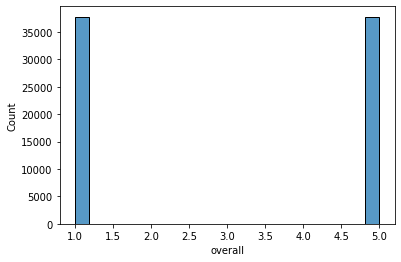

In [24]:
# sample resulf of sampling
sns.histplot(dfdataValidTrain['overall'])

In [25]:
statistics.variance(dfdataValidTrain.groupby(by=['overall'])['overall'].count().values)

0

<center>
    <h3>New Function</h3>
</center>

In [27]:
import gensim

In [28]:
import multiprocessing

In [29]:
cores = multiprocessing.cpu_count()

In [36]:
# train w2v model (skipgram)
training_corpus = [x.split() for x in tdf1['reviewText'].tolist()]
w2v_model = gensim.models.word2vec.Word2Vec(training_corpus, epochs=1, vector_size=500, sample=6e-5,alpha=0.03, min_alpha=0.0007, window=8, min_count=5, workers=cores-1)
w2v_model.init_sims(replace=True)

In [37]:
w2v_model.wv['great__JJ__1'].shape

(500,)

In [38]:
w2v_model.wv.most_similar('great__JJ__1')

[('work__NN__1', 0.9997074604034424),
 ('pleased__JJ__1', 0.9996148347854614),
 ('sound__NN__1', 0.9995705485343933),
 ('works__VBZ__1', 0.9994492530822754),
 ('quality__NN__1', 0.9993568062782288),
 ('!__.__1', 0.9993370175361633),
 ('go__VBP__1', 0.9990997314453125),
 ('nice__JJ__1', 0.998856782913208),
 ('tested__VBD__1', 0.9988380670547485),
 ('very__RB__1', 0.9987636804580688)]

In [39]:
minans, maxans = 10e23, -10e23
for i in range(len(w2v_model.wv.key_to_index)):
    minans = min(minans, np.array(w2v_model.wv.vectors[i]).mean(axis=0))
    maxans = max(maxans, np.array(w2v_model.wv.vectors[i]).mean(axis=0))
print("min: {}, max: {}".format(minans, maxans))

min: -0.005561493802815676, max: 0.005800939630717039


In [40]:
np.array(w2v_model.wv.vectors[w2v_model.wv.key_to_index["great__JJ__1"]]).mean(axis=0)

-0.0018541629

In [41]:
import statistics
statistics.mean(w2v_model.wv["great__JJ__1"])

-0.0018541632

In [42]:
from tensorflow.keras import models, layers, preprocessing as kprocessing

In [44]:
# tokenize text
tokenizer = kprocessing.text.Tokenizer(lower=True, split=' ', oov_token="NaN")
tokenizer.fit_on_texts(training_corpus)
dic_vocabulary = tokenizer.word_index
dic_vocabulary

{'NaN': 1,
 '.__.__3': 2,
 '.__.__2': 3,
 'the__dt__2': 4,
 'the__dt__3': 5,
 '.__.__5': 6,
 'the__dt__1': 7,
 '.__.__4': 8,
 '.__.__1': 9,
 'the__dt__4': 10,
 ',__,__2': 11,
 ',__,__3': 12,
 'it__prp__2': 13,
 'and__cc__2': 14,
 'and__cc__3': 15,
 'to__to__3': 16,
 'i__nn__1': 17,
 'it__prp__3': 18,
 ',__,__1': 19,
 'to__to__2': 20,
 'it__prp__1': 21,
 ',__,__4': 22,
 'it__prp__4': 23,
 'to__to__4': 24,
 'and__cc__1': 25,
 'a__dt__1': 26,
 'and__cc__4': 27,
 'this__dt__1': 28,
 'to__to__1': 29,
 'a__dt__4': 30,
 'a__dt__3': 31,
 'a__dt__2': 32,
 'i__nn__3': 33,
 'i__nn__2': 34,
 'for__in__1': 35,
 'this__dt__4': 36,
 'i__nn__4': 37,
 'is__vbz__1': 38,
 'my__prp$__1': 39,
 'is__vbz__3': 40,
 'of__in__1': 41,
 'is__vbz__2': 42,
 'for__in__4': 43,
 'is__vbz__4': 44,
 'of__in__2': 45,
 'of__in__4': 46,
 'my__prp$__2': 47,
 'of__in__3': 48,
 'for__in__3': 49,
 'for__in__2': 50,
 'was__vbd__1': 51,
 'not__rb__1': 52,
 'my__prp$__3': 53,
 'not__rb__4': 54,
 'this__dt__3': 55,
 'not__rb__3': 

In [46]:
# create sequence
lst_text2seq= tokenizer.texts_to_sequences(training_corpus)
lst_text2seq

[[7,
  8239,
  38,
  8394,
  25,
  4,
  337,
  42,
  280,
  225,
  31,
  269,
  4554,
  16,
  18,
  27,
  44,
  44770,
  943,
  60788],
 [236,
  105,
  27340,
  9,
  11626,
  60789,
  1717,
  408,
  52,
  1291,
  192,
  13,
  42,
  1041,
  184,
  192,
  13,
  42,
  5091,
  12,
  82,
  5,
  932,
  1674,
  74,
  5,
  19590,
  14665,
  4555,
  1173,
  10,
  1447,
  17507,
  117,
  23,
  44,
  9137,
  6028,
  6],
 [6892],
 [79, 96, 89, 317, 214, 11, 2937, 269, 12, 15, 53, 4805, 2504, 23, 61],
 [79, 3309, 50, 31, 208, 259, 6],
 [1991,
  9,
  21,
  3117,
  39,
  44771,
  2021,
  266,
  26,
  8395,
  9,
  6707,
  538,
  155,
  20847,
  794,
  267,
  3,
  2022,
  13,
  106,
  14,
  18,
  1159,
  269,
  2,
  55,
  40,
  5,
  8754,
  142,
  33,
  520,
  2210,
  8,
  3489,
  30,
  1737,
  46,
  970,
  8,
  1933,
  286,
  6],
 [28,
  38,
  26,
  79,
  1793,
  9,
  94,
  392,
  29,
  1354,
  25,
  7,
  1258,
  317,
  4221,
  3,
  4,
  11002,
  42,
  165,
  6893,
  14,
  4,
  14086,
  64,
  4,
  503

In [47]:
# padding sequence
X_train = kprocessing.sequence.pad_sequences(lst_text2seq, maxlen=15, padding="post", truncating="post")
X_train

array([[    7,  8239,    38, ...,  4554,    16,    18],
       [  236,   105, 27340, ...,    42,  1041,   184],
       [ 6892,     0,     0, ...,     0,     0,     0],
       ...,
       [  632, 22073,     0, ...,     0,     0,     0],
       [   28,   780,   922, ...,    21,  2321,  5333],
       [   17,   937,    39, ...,  2965,     7, 19992]])

In [ ]:
# Create embedding layer
# Embedding the text
# Create network

<div style="white-space:pre-line">Option1
Data: 300, 111727
Layer1: {Input: (300, 111727) -> Output: (300, 100)} = 100 Neurons
Flattened
Layer2: {Input: (1, 30000) -> Output: (1, 100)} = 100 Neurons
Output: {Input: (100, ) -> Output: (2, )} = 2 Neurons
</div>

<div style="white-space:pre-line"> Option2
Data1-Data300: 1, 111727
Layer1-Layer300: {Input: (1, 111727) -> Output: (1, 1)} = 1 Neurons => It is 1 Neurons for each dimension
Output: {Input: (100, ) -> Output: (2, )} = 2 Neurons
</div>

<div style="white-space:pre-line"> Option3
Data1-Data300: 1, 111727
Layer1-Layer300: {Input: (1, 111727) -> Output: (1, 100)} = 100 Neurons => It is 100 Neurons for each dimension
Layer301: {Input: (1, 30000)} -> Output: (1, 100)} = 100 Neurons
Output: {Input: (100, ) -> Output: (2, )} = 2 Neurons
</div>

In [61]:
import torch
import tensorflow

<center>
    <h3>Process</h3>
</center>

In [26]:
def pipeline(txt: str) -> str:
    txt = pipe_cleaningText(txt)
    txt = pipe_addPos(txt)
    txt = pipe_normalized(txt, 5, tokenized=True)
    return txt

tdf1 = dfdataValidTrain.copy()
tdf2 = dfdataValidTest.copy()
tdf1['reviewText'] = tdf1['reviewText'].apply(lambda x: pipeline(x))
tdf2['reviewText'] = tdf2['reviewText'].apply(lambda x: pipeline(x))
tdf1['lenW'] = tdf1['reviewText'].apply(lambda x: len(x))
tdf2['lenW'] = tdf2['reviewText'].apply(lambda x: len(x))